# Import libraries

In [1]:
import tensorflow as tf 
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

2023-04-10 16:26:12.170929: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 16:26:12.698658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/airi/anaconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Transfer Learning via VGG-19
#### 1.1 Load dataset

In [2]:
ds, info = tfds.load('dmlab', split = 'train', shuffle_files=True, data_dir='/home/airi/Makhmud/dmlab/', with_info=True)

2023-04-10 16:26:14.295063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-10 16:26:14.295354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-10 16:26:14.326500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

#### 1.2 Split dataset(trainm test, and valid)

In [ ]:
ds_train = tfds.load('dmlab', split = 'train', shuffle_files=True, data_dir='/home/airi/Makhmud/dmlab/')
ds_test = tfds.load('dmlab', split = 'test', data_dir='/home/airi/Makhmud/dmlab/')
ds_valid = tfds.load('dmlab', split = 'validation', shuffle_files=True, data_dir='/home/airi/Makhmud/dmlab/')

#### 1.3 Visualization

2023-04-10 14:28:22.222055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [16]
	 [[{{node Placeholder/_0}}]]
2023-04-10 14:28:22.222354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [16]
	 [[{{node Placeholder/_2}}]]


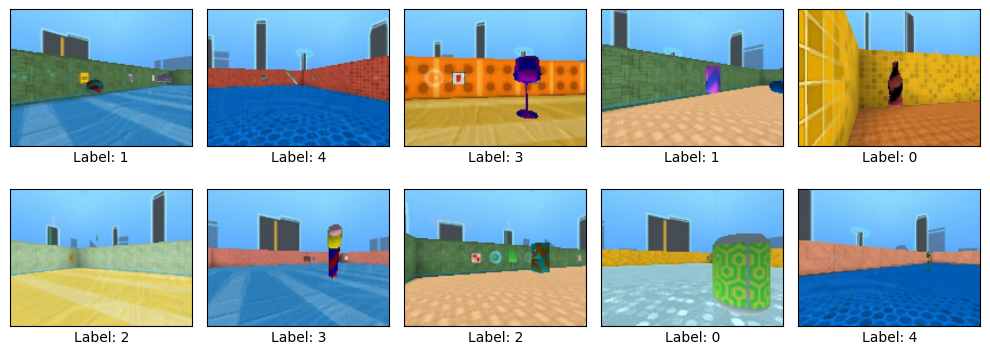

In [3]:
# Create a figure with a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 10))

# Iterate over the first 10 elements of ds_train and display their images and labels in the subplots
for i, example in enumerate(ds_train.take(10)):
    image = example['image'].numpy()
    label = example['label'].numpy()
    ax = axes[i//5, i%5]  # Get the subplot corresponding to the current element
    ax.imshow(image)
    ax.text(image.shape[1]/2, image.shape[0]+40, f"Label: {label}", ha='center', fontsize=10, color='black')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout(h_pad = -7)

# Display the figure
plt.show()

#### 1.4 Data preprocessing

In [87]:
img_width, img_height = 224, 224 
channels = 3
batch_size = 64

In [88]:
# Normalize the images in the dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)
ds_train_normalized = ds_train.map(lambda x: (normalization_layer(x['image']), x['label']))
ds_test_normalized = ds_test.map(lambda x: (normalization_layer(x['image']), x['label']))
ds_valid_normalized = ds_valid.map(lambda x: (normalization_layer(x['image']), x['label']))

In [89]:
### Resize shape
ds_train_resized = ds_train_normalized.map(lambda x, y: (tf.image.resize(x, (img_width, img_height)), y)).batch(batch_size)
ds_test_resized = ds_test_normalized.map(lambda x, y: (tf.image.resize(x, (img_width, img_height)), y)).batch(batch_size)
ds_valid_resized = ds_valid_normalized.map(lambda x, y: (tf.image.resize(x, (img_width, img_height)), y)).batch(batch_size)


In [104]:
for i, example in enumerate(ds_train_resized.take(10)):  #### View image's shape
    image = example[0].shape
    label = example[1]
    print(image)
    break  

(64, 224, 224, 3)


2023-04-10 12:51:11.120779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [16]
	 [[{{node Placeholder/_4}}]]
2023-04-10 12:51:11.121439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [16]
	 [[{{node Placeholder/_3}}]]


#### 1.5 Classes' name

In [102]:
zero = 0
one = 0
two = 0
three = 0
four = 0
five = 0

for i, example in enumerate(ds_train.take(len(ds_train))):
    label = example['label'].numpy()
    if label == 0:
        zero += 1
    elif label == 1:
        one += 1
    elif label == 2:
        two += 1
    elif label == 3:
        three += 1
    elif label == 4:
        four += 1
    else:
        five += 1 
        
print(f"label_0: {zero}", f"label_1: {one}", f"label_2: {two}", f"label_3: {three}", f"label_4: {four}", f"label_5: {five}")

2023-04-10 12:50:27.953937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [16]
	 [[{{node Placeholder/_4}}]]
2023-04-10 12:50:27.954422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [16]
	 [[{{node Placeholder/_1}}]]


label_0: 14749 label_1: 12539 label_2: 10298 label_3: 11222 label_4: 9295 label_5: 7447


#### 1.6 To build the model via VGG-19

In [90]:
vgg19 = tf.keras.applications.vgg19.VGG19(include_top=False, input_shape= (img_width, img_height, channels), weights='imagenet')
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model = Sequential()
for layer in vgg19.layers:
    layer.trainable = False #o turn off VGG19's trainable weights
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary()

In [ ]:
# To select the optimizer ans the loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

#### 1.7 Callbacks

In [ ]:
checkpoint = ModelCheckpoint(
    'model_vgg19.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)
csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)
reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)
callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [ ]:
# Compile the model
model_vgg19.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])

In [95]:
### To fit the model
history = model.fit(
    ds_train_resized, 
    epochs = 10,
    validation_data = ds_valid_resized, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/10


2023-04-10 12:11:15.276271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [16]
	 [[{{node Placeholder/_3}}]]
2023-04-10 12:11:15.276883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [16]
	 [[{{node Placeholder/_2}}]]


1025/1025 [==============================] - ETA: 0s - loss: 1.3315 - accuracy: 0.4666

2023-04-10 12:14:52.053534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [8]
	 [[{{node Placeholder/_3}}]]
2023-04-10 12:14:52.053882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [8]
	 [[{{node Placeholder/_1}}]]



Epoch 1: val_loss improved from inf to 1.20057, saving model to model_vgg19.h5
1025/1025 [==============================] - 289s 279ms/step - loss: 1.3315 - accuracy: 0.4666 - val_loss: 1.2006 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 2/10
1025/1025 [==============================] - ETA: 0s - loss: 1.0690 - accuracy: 0.5586
Epoch 2: val_loss improved from 1.20057 to 1.19011, saving model to model_vgg19.h5
1025/1025 [==============================] - 284s 278ms/step - loss: 1.0690 - accuracy: 0.5586 - val_loss: 1.1901 - val_accuracy: 0.5074 - lr: 0.0010
Epoch 3/10
1025/1025 [==============================] - ETA: 0s - loss: 0.9901 - accuracy: 0.5937
Epoch 3: val_loss improved from 1.19011 to 1.15217, saving model to model_vgg19.h5
1025/1025 [==============================] - 288s 281ms/step - loss: 0.9901 - accuracy: 0.5937 - val_loss: 1.1522 - val_accuracy: 0.5080 - lr: 0.0010
Epoch 4/10
1025/1025 [==============================] - ETA: 0s - loss: 0.9389 - accuracy: 0.6150
Epoch 4: v

#### 1.8 Evaluate

In [96]:
model.evaluate(ds_test_resized)

2023-04-10 12:41:58.405880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [8]
	 [[{{node Placeholder/_4}}]]
2023-04-10 12:41:58.406177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [8]
	 [[{{node Placeholder/_2}}]]


356/356 [==============================] - 72s 201ms/step - loss: 1.2420 - accuracy: 0.5288


[1.2419806718826294, 0.528832197189331]

#### 1.9 Load the model 

In [80]:
# load the model
model_vgg19 = tf.keras.models.load_model('model_vgg19.h5')

## Build model with Transfer Learning via Tensorflow from scratch

In [ ]:
class TransferModel(Model):
    def __init__(self):
        super(TransferModel, self).__init__()
        self.pre_model = tf.keras.applications.VGG19(weights='imagenet' , input_shape = (224,224,3) , include_top=False)
        self.pre_model.trainable = False
        self.flatten = Flatten()
        self.d = Dense(2048 , activation = 'relu')
        self.drop = Dropout(0.2)
        self.d1 = Dense(1024 , activation = 'relu')
        self.d2 = Dense(128 , activation = 'relu')
        self.d3 = Dense(6  , activation = 'softmax')

    def call(self, x):
        x = self.pre_model(x)
        x = self.flatten(x)
        x = self.d(x)
        x = self.drop(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        return x

In [ ]:
model_transfer = TransferModel()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
@tf.function
def train_step_transfer(x_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model_transfer(x_train, training=True)
        loss = loss_object(y_train, predictions)
    gradients = tape.gradient(loss, model_transfer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_transfer.trainable_variables))

    train_loss(loss)
    train_accuracy(y_train, predictions)

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()

    for images , labels in dataset:
        train_step_transfer(images , labels)
        
    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result()}, '
  )

In [ ]:
model_transfer.summary()

In [ ]:
save_model(model_transfer , 'model_with_transfer')

## To build architecture from scratch
#### 2.1 Architecture

In [55]:
# Define your model
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding = 'same')
        self.conv2 = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding = 'same')
        self.conv3 = Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding = 'same')
        self.conv4 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding = 'same')
        self.pooling = MaxPooling2D(pool_size = (2, 2), strides = 2)
        self.drop1 = Dropout(rate = 0.2)
#         self.drop2 = Dropout(rate = 0.5)
        self.flatten = Flatten()
        self.d1 = Dense(2048, activation='relu')
        self.d2 = Dense(512, activation='relu')
        self.d3 = Dense(64, activation='relu')
        self.dense_output = Dense(6, activation = 'softmax')  

    def call(self, x):
        conv1_1 = self.conv1(x)
        pool = self.pooling(conv1_1)
        conv2_2 = self.conv2(pool)
        pool = self.pooling(conv2_2)
        conv3_3 = self.conv3(pool)
        pool = self.pooling(conv3_3)
        conv4_4 = self.conv4(pool)
        pool = self.pooling(conv4_4)
        flatten_1  = self.flatten(pool)
        
        hidden_1 = self.d1(flatten_1)
        droping = self.drop1(hidden_1)
        
        hidden_2 = self.d2(droping)
        
        hidden_3 = self.d3(hidden_2)
        
        return self.dense_output(hidden_3)

# Create an instance of the model
model = MyModel()

In [56]:
# Define your loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Define your optimizer
optimizer = tf.keras.optimizers.Adam()

In [57]:
# Define your metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [58]:
# Define the checkpoint directory and file name
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# Define the callback for saving the model
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


#### 2.2 Train process

In [59]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

####  2.3 Test process

In [60]:
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

#### 2.4 Data preprocessing

In [61]:
ds, info = tfds.load('dmlab', split = 'train', shuffle_files=True, data_dir='/home/airi/Makhmud/dmlab/', with_info=True)
ds_train = tfds.load('dmlab', split = 'train', shuffle_files=True, data_dir='/home/airi/Makhmud/dmlab/')
ds_test = tfds.load('dmlab', split = 'test', data_dir='/home/airi/Makhmud/dmlab/')
ds_valid = tfds.load('dmlab', split = 'validation', shuffle_files=True, data_dir='/home/airi/Makhmud/dmlab/')

In [62]:
img_width, img_height = 224, 224 
channels = 3
batch_size = 16

In [63]:
# Normalize the images in the dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)
ds_train_normalized = ds_train.map(lambda x: (normalization_layer(x['image']), x['label']))
ds_test_normalized = ds_test.map(lambda x: (normalization_layer(x['image']), x['label']))
ds_valid_normalized = ds_valid.map(lambda x: (normalization_layer(x['image']), x['label']))

In [64]:
### Resize shape
ds_train_resized = ds_train_normalized.map(lambda x, y: (tf.image.resize(x, (img_width, img_height)), y)).batch(batch_size)
ds_test_resized = ds_test_normalized.map(lambda x, y: (tf.image.resize(x, (img_width, img_height)), y)).batch(batch_size)
ds_valid_resized = ds_valid_normalized.map(lambda x, y: (tf.image.resize(x, (img_width, img_height)), y)).batch(batch_size)

#### 2.5 Fit

In [65]:
EPOCHS = 5

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for images, labels in ds_train_resized:
        train_step(images, labels)

    for test_images, test_labels in ds_valid_resized:
        test_step(test_images, test_labels)
        
    # Save the model after each epoch
    model.save_weights(checkpoint_prefix.format(epoch=epoch)) 
    
    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
    )

2023-04-10 17:05:12.376287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [16]
	 [[{{node Placeholder/_4}}]]
2023-04-10 17:05:12.376889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [16]
	 [[{{node Placeholder/_0}}]]
/home/airi/anaconda3/envs/tf/lib/python3.9/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-

Epoch 1, Loss: 1.2721312046051025, Accuracy: 43.78184509277344, Test Loss: 1.1723265647888184, Test Accuracy: 46.5396842956543
Epoch 2, Loss: 1.0689975023269653, Accuracy: 54.48664855957031, Test Loss: 1.1635334491729736, Test Accuracy: 50.34029006958008
Epoch 3, Loss: 0.8910481333732605, Accuracy: 63.295196533203125, Test Loss: 1.244288682937622, Test Accuracy: 51.48488998413086
Epoch 4, Loss: 0.6972854733467102, Accuracy: 72.15408325195312, Test Loss: 1.4618533849716187, Test Accuracy: 50.985504150390625
Epoch 5, Loss: 0.5152841806411743, Accuracy: 80.06864929199219, Test Loss: 1.81284761428833, Test Accuracy: 50.684993743896484


In [35]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           multiple                  224       
                                                                 
 conv2d_5 (Conv2D)           multiple                  1168      
                                                                 
 conv2d_6 (Conv2D)           multiple                  4640      
                                                                 
 conv2d_7 (Conv2D)           multiple                  18496     
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                        

In [36]:
# save the model in SavedModel format as tf
model.save('my_model', save_format='tf')

2023-04-10 16:50:29.715930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]
2023-04-10 16:50:30.004787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [37]:
# load the model
loaded_model = tf.keras.models.load_model('my_model')

In [50]:
a = loaded_model.predict(ds_test_resized)

1421/1421 [==============================] - 5s 3ms/step


In [51]:
np.argmax(a[0:16], axis = 1)

array([3, 0, 0, 0, 5, 2, 0, 1, 1, 0, 0, 4, 0, 1, 3, 0])

In [53]:
labels = []
for i, example in enumerate(ds_valid.take(16)):
    label = example['label'].numpy()
    labels.append(label)
    

2023-04-10 16:56:30.190436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [8]
	 [[{{node Placeholder/_3}}]]
2023-04-10 16:56:30.190918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [8]
	 [[{{node Placeholder/_1}}]]


In [54]:
labels

[1, 1, 4, 5, 4, 4, 4, 0, 1, 0, 0, 3, 3, 4, 4, 1]

In [52]:
for image, label, in ds_test_resized:
    print(label)
    break

tf.Tensor([3 0 1 1 2 2 0 4 4 3 0 2 3 2 3 3], shape=(16,), dtype=int64)
